In [1]:
import pickle
from keras.src.models.model import model_from_json
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
model_file_path = '../../AIModels/BaselineModel/20Epochs/'

In [3]:
with open(model_file_path + 'DrivingComfortabilityPredictingModel.json', 'r') as json_file:
    model_json = json_file.read()
loaded_baseline_model = model_from_json(model_json)

loaded_baseline_model.load_weights(model_file_path + 'DrivingComfortabilityPredictingModel.weights.h5')

loaded_baseline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

with open(model_file_path + 'DrivingComfortabilityPredictingModelHistory.pkl', 'rb') as history_file:
    history = pickle.load(history_file)

loaded_baseline_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,404 (9.39 KB)

 Trainable params: 2,404 (9.39 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from sklearn.preprocessing import LabelEncoder

dataframe = pd.read_csv('../../Data/Verified/BaseLineLabeledWithoutSelfLabeledValues/RecordedDrivingData.csv')
acceleration_dataframe = dataframe[['Longitudinal acceleration','Lateral acceleration']]
labels_dataframe = dataframe['Label']
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_dataframe)
acceleration_dataframe.describe()

,Longitudinal acceleration,Lateral acceleration
count,226203.000000,226203.000000
mean,-0.089792,0.363585
std,0.481765,0.643068
min,-3.982860,-5.052150
25%,-0.292000,0.120000
50%,-0.097000,0.390000
75%,0.097000,0.640000
max,2.982240,6.003720


7069/7069 ━━━━━━━━━━━━━━━━━━━━ 5s 749us/step
7069/7069 ━━━━━━━━━━━━━━━━━━━━ 5s 612us/step - accuracy: 0.8747 - loss: 1.2190
Loss: 1.1790642738342285
Accuracy: 0.8745242357254028


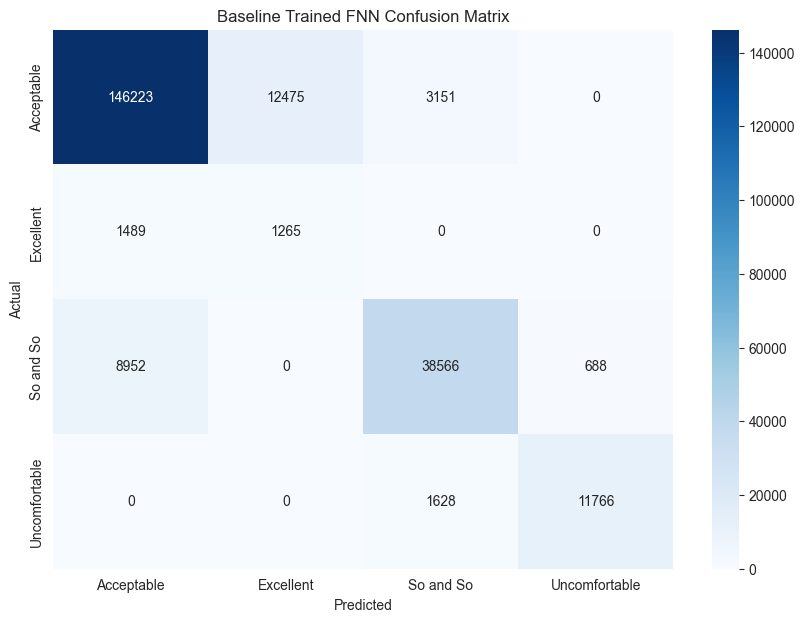

In [5]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test data
test_data_predictions = loaded_baseline_model.predict(acceleration_dataframe)
test_labels_predictions = np.argmax(test_data_predictions, axis=1)

# Evaluate the model
loss, accuracy = loaded_baseline_model.evaluate(acceleration_dataframe, encoded_labels)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# Create confusion matrix
cm = confusion_matrix(encoded_labels, test_labels_predictions)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Baseline Trained FNN Confusion Matrix')
plt.show()


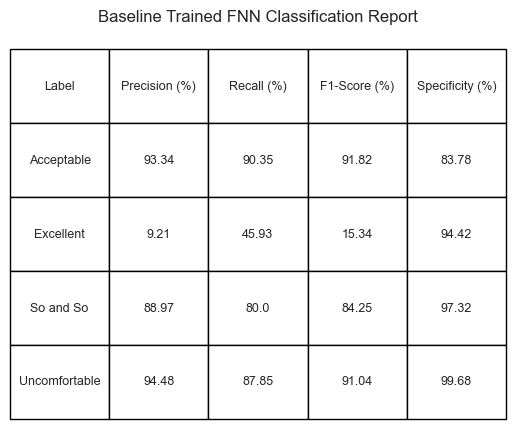

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Assuming Test_Labels and test_labels_predictions are already defined

# Get precision, recall, and f1-score
precision, recall, f1, _ = precision_recall_fscore_support(encoded_labels, test_labels_predictions, average=None)

specificity = []
for i in range(len(cm)):
    tn = np.sum(cm) - (np.sum(cm[:, i]) + np.sum(cm[i, :]) - cm[i, i])
    fp = np.sum(cm[:, i]) - cm[i, i]
    specificity.append(tn / (tn + fp))

# Create a DataFrame for the scores
labels = label_encoder.inverse_transform([0, 1, 2, 3])
scores_df = pd.DataFrame({
    'Label': labels,
    'Precision (%)': (precision * 100).round(2),
    'Recall (%)': (recall * 100).round(2),
    'F1-Score (%)': (f1 * 100).round(2),
    'Specificity (%)': (np.array(specificity) * 100).round(2)
})

# Plotting the table
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
ax.table(cellText=scores_df.values, colLabels=scores_df.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

plt.title('Baseline Trained FNN Classification Report', pad=20)
plt.show()
